# Classifying flowers with Fastaiv2

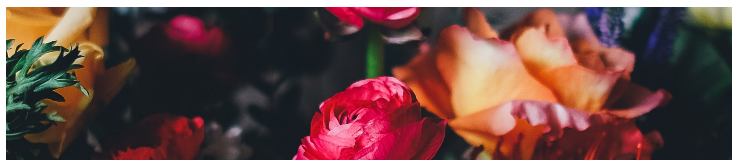


    
**In this kernel, I will briefly explain how to participate in this competition with latest version of fastaiv2, which is scheduled to be released on early June.**


<font size=3 color="red">Please upvote this kernel if you like it. It motivates me to produce more quality content :)</font>

# Contents

* [<font size=4>Installation</font>](#1)
* [<font size=4>Flower classification - High level API</font>](#2)
* [<font size=4>Flower classification - low level API</font>](#3)
* [<font size=4>Train Model</font>](#4)
* [<font size=4>Look at our results</font>](#5)
* [<font size=4>Ending Note</font>](#6)

# Acknowledgment

This notebook is a product of my experience participating in fastai2 megastudy group conducted by Zach Mueller. More details about the online study group and fantastic fastai2 resources can be found in the [Practical Deep Learning for Coders 2.0 repo](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0)

# Installation <a id='1'>

In [ ]:
! pip install fastai2

Just importing the libraries, this is a bad practice of importing everthing, don't you know that?


In [ ]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *
import matplotlib.pyplot as plt

# Flower classification - High level API <a id='2'>

In [ ]:
# Load the data
flower_path = '/kaggle/input/104-flowers-garden-of-eden/jpeg-512x512'
TRAIN_DIR  = flower_path + '/train'
VAL_DIR  = flower_path + '/val'
TEST_DIR  = flower_path + '/test/'

Now that we know this, let's build a basic transformation pipeline that looks something like so:

- Resize our images to a fixed size (224x224 pixels)
- After they are batched together, choose a quick basic augmentation function
- Normalize all of our image data

Let's build it!

In [ ]:
item_tfms = Resize(256)
batch_tfms = [RandomResizedCrop(224), *aug_transforms(mult=1.0, do_flip=True, max_rotate=30.0, max_zoom=1.5,
                            max_lighting=.8, max_warp=0.3, p_lighting=.9)]
bs=128

As noted earlier, there are two kinds of transforms: `item_tfms and batch_tfms`. Each do what it sounds like: an item transform is applied on an individual item basis, and a batch transform is applied over each batch of data. The role of the item transform is to prepare everything for a batch level (and to apply any specific item transformations you need), and the batch transform is to further apply any augmentations on the batch level efficently (normalization of your data also happens on a batch level). One of the biggest differences between the two though is where each is done. Item transforms are done on the CPU while batch transforms are performed on the GPU.

In [ ]:
# High level fastai API using fastai
data = ImageDataLoaders.from_folder(flower_path, valid='val',batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

Calling ImageDataloader and specifying flower_path, trasformations and batch size

In [ ]:
# total no of classes
data.c

In [ ]:
data.vocab

In [ ]:
data.show_batch(max_n=9)

# Flower classification - medium-level API <a id='3'>

We'll all wrap them up in a nice little package of a DataBlock. Think of the DataBlock as a list of instructions to do when we're building batches and our DataLoaders. It doesn't need any items explicitly to be done, and instead is a blueprint of how to operate. We define it like so:

In [ ]:
path = Path(flower_path+'/train/')
path.ls()

In [ ]:
flower_blocks = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(valid_name='val'),
                   get_y=[parent_label],
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, max_rotate=30, min_scale=0.75))

In [ ]:
dls = flower_blocks.dataloaders(TRAIN_DIR,  bs=32)

In [ ]:
dls.show_batch(max_n=9)

In [ ]:
block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 splitter=RandomSplitter(),
                 get_items=get_image_files,
                 get_y=parent_label,
                 batch_tfms=batch_tfms)

In [ ]:
dls = block.dataloaders(path, bs=32)

In [ ]:
dls.show_batch()

# Train model <a id='4'>

In [ ]:
from torchvision.models import resnet50
from fastai2.metrics import accuracy_multi

In [ ]:
from sklearn.model_selection import StratifiedKFold

We used 5 Folds for K-Fold Cross Validation, we'll recreate the process based on this notebook. We'll also use a few different image augmentations and Test Time Augmentation (TTA).

In [ ]:
imgs = get_image_files(path)
random.shuffle(imgs)
lbls = [parent_label(im) for im in imgs]

In [ ]:
def get_dls(bs, size, val_idx):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=IndexSplitter(val_idx),
                   item_tfms = Resize(256),
                   batch_tfms = [RandomResizedCrop(size), 
                                 *aug_transforms(mult=1.0, do_flip=True, 
                                                 max_rotate=30.0, max_zoom=1.5,
                                                  max_lighting=.8, max_warp=0.3, 
                                                 p_lighting=.9),
                                 Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)



We'll also be utilizing the progressive resizing technique, where we train initially on a smaller set of images before moving upwards to a larger size. We're doing this as our data comes from a variety of sized images, so this will be a good way to get the most out of our data.

Now you're probably confused about the difference between pre-sizing and progressive resizing. I'll try to explain the difference. Pre-sizing is where we initially make our image larger before applying a random crop of the image (such as 256x256 to 224x224). This can bring an opportunity for some smaller or finer details to show up more prominantly.

Progressive resizing is a technique where we start training at a small image size and then increase this image size while training. Here we'll start at an image size of 128x128 and then train on an image size of 224x224 afterwards

Now let's make a function to help us build our DataLoaders in such a way as to support progressive resizing


In [ ]:
%%time
val_pct = []
skf = StratifiedKFold(n_splits=3, shuffle=True)
i = 0

for _, val_idx in skf.split(np.array(imgs), lbls):
    dls = get_dls(32, 128, val_idx)
    learn = cnn_learner(dls, resnet50, metrics=accuracy)
    learn.fine_tune(2, cbs=[EarlyStoppingCallback(monitor='accuracy')])
    learn.dls = get_dls(32, 224, val_idx)
    learn.fine_tune(3, 1e-3, cbs=[EarlyStoppingCallback(monitor='accuracy')])
    preds, targs = learn.tta()
    print(accuracy(preds, targs).item())
    val_pct.append(accuracy(preds, targs).item())
    i+=1

# Look at our results <a id='5'>

In [ ]:
interep = ClassificationInterpretation.from_learner(learn)
losses, idxs = interep.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interep.plot_top_losses(9, figsize=(15,10))

In [ ]:
interep.plot_confusion_matrix(figsize=(25,25
                                    ), dpi=60)

In [ ]:
interep.most_confused(min_val=3)

# Submit predictions

In [ ]:
sub= pd.read_csv('/kaggle/input/flower-classification-with-tpus/sample_submission.csv')

In [ ]:
sub.head()

In [ ]:
n = sub.shape[0]
test_folder = TEST_DIR  

In [ ]:
img = plt.imread(TEST_DIR+'416e24d42.jpeg')
print(learn.predict(img)[0])
img


In [ ]:
# for i in range(n):
#   idc = sub.iloc[i][0]
#   k = TEST_DIR + idc + '.jpeg'
#   k = plt.imread(k)
#   ans = learn.predict(k)[0]
#   sub.loc[[i],1:] = str(ans)

# print("Done Prediction saved ---> ")

In [ ]:
# sub.head()

# Ending note <a id="6"></a>

<font size=4 color="red">This concludes my fastai2 kernel. Please upvote this kernel if you like it. It took me more 30 hours to write this kernel to get familarised with fastai2 </font>